In [2]:
from transformers import SegformerForSemanticSegmentation

In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn

from transformers import get_linear_schedule_with_warmup
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# from segmenter import Segmenter
from segmenter_ver_2 import create_segmenter

/home/oaz/miniconda3/envs/ccp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/oaz/miniconda3/envs/ccp/lib/python3.11/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

class VOCDataset(Dataset):
    def __init__(self, root="./dataset/pascal_2012/VOCdevkit/VOC2012",
                 is_train=True, transform=None, classes=None):
        # Choose the file for training or validation images
        if is_train:
            img_root = os.path.join(root, "ImageSets", "Segmentation", "train.txt")
        else:
            img_root = os.path.join(root, "ImageSets", "Segmentation", "val.txt")
        
        # Get image names into list
        img_names = []
        with open(img_root, 'r') as rf:
            names = [name.replace('\n','') for name in rf.readlines()]
            for name in names:
                img_names.append(name)
            
        self.classes =  classes
        self.transform = transform
        self.img_names = img_names
        self.root = root
        
    def __len__(self):
        return len(self.img_names)
    
    def _convert_to_segmentation_mask(self, mask):
        height, width = mask.shape[:2]
        # Initialize an empty mask with a channel for each class
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)))
        
        # Create a mask for each class label
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        
        return segmentation_mask

    
    def __getitem__(self, item):
        img_name = self.img_names[item]
        # Load the image and corresponding mask
        img = cv2.imread(os.path.join(self.root, "JPEGImages", img_name + ".jpg"))
        mask = cv2.imread(os.path.join(self.root, "SegmentationClass", img_name + ".png"))
        
        # Convert BGR to RGB format
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        # Convert RGB mask to segmentation mask
        mask = self._convert_to_segmentation_mask(mask)
        
        # Apply transformations if specified
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            mask = mask.argmax(dim=2).squeeze()  # Convert multi-channel mask back to single-channel
        
        return img, mask

In [3]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [4]:
trainsform = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
    ToTensorV2(),
])

VOC_dataset = VOCDataset(is_train= True, transform = trainsform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6225708].


41 9
Img: torch.Size([3, 224, 224])
Mask: torch.Size([224, 224])
Max Value Img: tensor(2.6400)
Max Value Mask: 11 | Unique Value Mask: tensor([ 0,  9, 11])


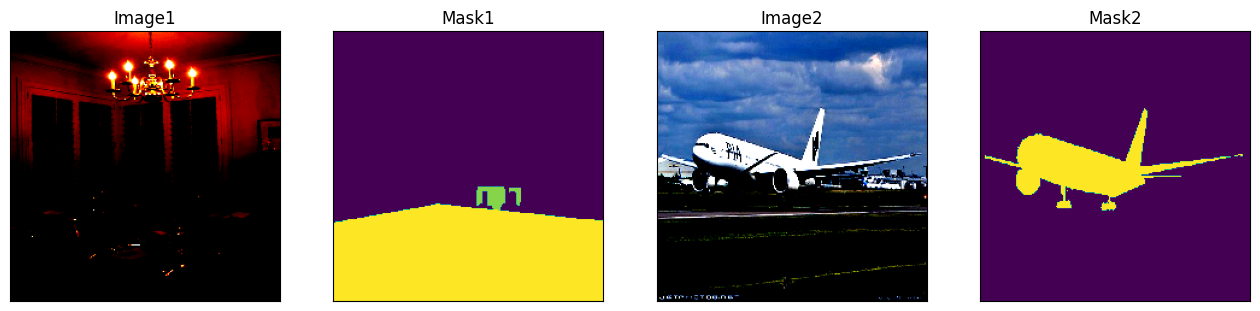

In [5]:
idx1, idx2 = np.random.randint(1,500), np.random.randint(1,500)
print(idx1,idx2)
img, mask = VOC_dataset[idx1]
img2, mask2 = VOC_dataset[idx2]
print("Img:", img.shape)
print("Mask:", mask.shape)
print("Max Value Img:",img.max())
print("Max Value Mask: {} | Unique Value Mask: {}".format(mask.max(), mask.unique()))

visualize(
    image1=img.permute(1,2,0), 
    mask1=mask.squeeze(),
    image2 = img2.permute(1,2,0),
    mask2 = mask2.squeeze(),
)

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

In [7]:
# transform_size = 257
#Define trainform to images
def img_transform(trainsize= 224):
    train_transform = A.Compose([
    A.Rotate([-10,10]),
    A.RandomScale([0.5,2]),
    A.GaussianBlur(),
    A.HorizontalFlip(),
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
    ])

    test_transform = A.Compose([
        A.Resize(width=trainsize, height=trainsize),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
        ToTensorV2(), 
    ])
    return train_transform, test_transform

In [8]:
import copy

#patience, min_delta, restore_best_weights, best_model, best_loss counter status
#copy.deepcopy
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=False):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        """
        Call method to check if early stopping is triggered.

        Args:
        model (torch.nn.Module): The model being trained.
        val_loss (float): The validation loss of the current epoch.

        Returns:
        bool: True if early stopping should occur, False otherwise.
        """
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())

        elif self.best_loss - val_loss > self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0

        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stop on {self.counter}"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True  # Stop training
        self.status = f"{self.counter}/{self.patience}"
        return False # Continue training

In [9]:
import matplotlib.pyplot as plt

def plot_segmentation_metrics(train_loss, val_loss, train_mean_iou=None, val_mean_iou=None, 
                              train_dice_score=None, val_dice_score=None):
    """
    Plot training and validation metrics (loss, mean IoU, Dice score) over epochs.

    Args:
    - train_loss (list): List of training loss values over epochs.
    - val_loss (list): List of validation loss values over epochs.
    - train_mean_iou (list, optional): List of training mean IoU values over epochs.
    - val_mean_iou (list, optional): List of validation mean IoU values over epochs.
    - train_dice_score (list, optional): List of training Dice score values over epochs.
    - val_dice_score (list, optional): List of validation Dice score values over epochs.
    """
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(15, 10))
    
    # Plotting the Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plotting the Mean IoU (if available)
    if train_mean_iou and val_mean_iou:
        plt.subplot(2, 2, 2)
        plt.plot(epochs, train_mean_iou, 'r', label='Training Mean IoU')
        plt.plot(epochs, val_mean_iou, 'b', label='Test Mean IoU')
        plt.title('Training and Test Mean IoU')
        plt.xlabel('Epochs')
        plt.ylabel('Mean IoU')
        plt.legend()
    
    # Plotting the Dice Score (if available)
    if train_dice_score and val_dice_score:
        plt.subplot(2, 2, 3)
        plt.plot(epochs, train_dice_score, 'r', label='Training Dice Score')
        plt.plot(epochs, val_dice_score, 'b', label='Test Dice Score')
        plt.title('Training and Test Dice Score')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Score')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

In [10]:
upsample = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)

In [11]:
# Training fuction
def train(model,train_dataloader,device,optimizer, epoch, EPOCHS, writer, train_loss_meter, criterion):
    model.train()
    train_progress= tqdm(train_dataloader, colour="cyan")
    
    for idx, img_mask in enumerate(train_progress):
        img = img_mask[0].float().to(device) #img - B,C,H,W
        mask = img_mask[1].long().to(device) #label - B,H,W
        # y_pred = model(img).logits #B, 21, H, W
        # y_pred =  upsample(y_pred)
        # print("img shape => ", img.shape)
        y_pred = model(img)
        #Optimizer 
        optimizer.zero_grad()
        loss = criterion(y_pred, mask) 
        loss.backward()
        optimizer.step()
        
        train_loss_meter.update(loss.item())
        
        # tracking the loss function
        writer.add_scalar("Train/Loss", train_loss_meter.avg, epoch*len(train_dataloader)+idx)
        
        train_progress.set_description("TRAIN| Epoch: {}/{}| Iter: {}/{} | Train Loss: {:0.4f} | lr: {}".format(
            epoch+1, EPOCHS, idx, len(train_dataloader), loss, optimizer.param_groups[0]['lr']))
        
    return train_loss_meter.avg

In [12]:
#Evaluate function
def evaluate(model,val_dataloader,device, num_classes, intersection_meter, union_meter, target_meter, test_loss_meter, criterion):
    model.eval()
    
    with torch.no_grad():
        for idx, img_mask in enumerate(val_dataloader):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].long().to(device) #B W H

            # y_pred = model(img).logits #B, 21, H, W
            # y_pred = upsample(y_pred)

            y_pred = model(img)
            
            loss = criterion(y_pred, mask) 
            test_loss_meter.update(loss.item()) 
            
            # (B, 21, H, W) -> (B, 1, H, W) -> (B, H, W)
            y_pred = y_pred.argmax(dim=1).squeeze(dim=1)
            intersection, union, target = intersectionAndUnionGPU(y_pred.float(), mask.float(), num_classes)
            intersection, union, target = intersection.cpu().numpy(), union.cpu().numpy(), target.cpu().numpy()
            intersection_meter.update(intersection), union_meter.update(union), target_meter.update(target)
            
            if idx>35: break
            
        #compute acc, iou, dice
        accuracy_class = intersection_meter.sum / (target_meter.sum + 1e-10)
        iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)
        dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10) #vector 21D
        macc = np.mean(accuracy_class)
        miou = np.mean(iou_class) #mean vector 21D
        mdice = np.mean(dice_class) #mean vector 21D
        
    return macc, miou, mdice, test_loss_meter.avg

In [13]:
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import torch.nn.functional as F

import segmentation_models_pytorch as smp
import shutil
from tqdm import tqdm
# from transformers import SegformerForSemanticSegmentation, SegformerConfig

In [ ]:
def main(learning_rate, batch_size, epochs, num_workers, data_path, model_save_path, tensorboard_path, num_classes, checkpoint_path):
    
    # Create model save directory if it doesn't exist
    if not os.path.isdir(model_save_path):
        os.mkdir(model_save_path)
    # Creater tensorboard directory
    if os.path.isdir(tensorboard_path):
        shutil.rmtree(tensorboard_path)
    os.mkdir(tensorboard_path)
    
    
    # Data augmentation and preprocessing for training and testing
    train_transform, test_transform = img_transform()
    
    # Create datasets and dataloaders
    train_dataset = VOCDataset(is_train=True, transform=train_transform)
    test_dataset = VOCDataset(is_train=False, transform=test_transform)

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    
    # Load model and move it to the appropriate device
    # segformer_version = "nvidia/segformer-b3-finetuned-ade-512-512"
    # model = SegformerForSemanticSegmentation.from_pretrained(segformer_version)
    # in_channels = model.decode_head.classifier.in_channels
    # model.decode_head.classifier = torch.nn.Conv2d(in_channels, num_classes, kernel_size=(1, 1), stride=(1, 1))

    # # segmenter 선언
    # model = Segmenter(backbone='vit_base_patch16_384', 
    #                   num_classes=21, 
    #                   image_size=384, 
    #                   emb_dim=768,
    #                   hidden_dim=3082,
    #                   num_layers=12,
    #                   num_heads=12)
    # Deeplab 선언
    model_config = {"n_cls": 21,  
                    "image_size": (224, 224),
                    "patch_size": 16,
                    "decoder": {              
                         "name": "mask_transformer",
                         "n_layers":12,
                         "drop_path_rate": 0.2,
                         'dropout':0.1
                        },
                    "d_model": 768,
                    "backbone": "vit_base_patch16_224.orig_in21k_ft_in1k",
                    "n_layers": 12,
                    "n_heads": 12
                    }
                         
    model = create_segmenter(model_config)
    

    # Segformer 선언
    # segformer_version = "nvidia/segformer-b3-finetuned-ade-512-512"
    # model = SegformerForSemanticSegmentation.from_pretrained(segformer_version)
    # in_channels = model.decode_head.classifier.in_channels
    # model.decode_head.classifier = torch.nn.Conv2d(in_channels, num_classes, kernel_size=(1, 1), stride=(1, 1))

    # model_save_path = "./working/trained_model/"  # 예: "path/to/model/directory"
    # checkpoint_path = os.path.join(model_save_path, "best.h5")
    # if os.path.exists(checkpoint_path):
    #     checkpoint = torch.load(checkpoint_path)
    #     model.load_state_dict(checkpoint['model_state_dict'])

    
    model.to(device)
    
    # Initialize optimizer and loss function
    # num_classes = 21
    # class_weights = [0.1] + [1.0] * (num_classes - 1)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = smp.losses.DiceLoss(mode="multiclass", classes = num_classes, log_loss = False, from_logits = True, smooth=1e-8,ignore_index=0)
    
    # Best validation IoU for saving the best model
    best_predict = -1
    current_epoch = 0
                                   
    # Metrics
    train_loss_list = []
    test_loss_list = []
    train_loss_meter = AverageMeter()
    test_loss_meter = AverageMeter()
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    target_meter = AverageMeter()
    
    # Early Stop
    es = EarlyStopping(patience=14,restore_best_weights=False)
    
    # set up learning rate scheduler
    total_steps = len(train_dataloader) * epochs
    warmup_steps = int(total_steps * 0.1)
    # scheduler= optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold= 1e-4, min_lr=0)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,  # Warm-up steps
        num_training_steps=total_steps  # Total training steps
    )
    # difine Tensorboard    
    writer = SummaryWriter(tensorboard_path)
    
    
    # Training loop
    for epoch in range(current_epoch,epochs): #EPOCHS
        intersection_meter.reset()
        union_meter.reset()
        target_meter.reset()
        
        #Start training model
        train_loss = train(model,train_dataloader,device,optimizer, epoch, epochs, writer, train_loss_meter,criterion)
        acc, miou, dice, test_loss = evaluate(model,val_dataloader,device, num_classes, intersection_meter, union_meter, target_meter, test_loss_meter, criterion)
        
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        
        # write in tensorboard
        writer.add_scalar("Test/Acc", acc, epoch)
        writer.add_scalar("Test/mIOU", miou, epoch)
        writer.add_scalar("Test/Dice", dice, epoch)
        
        # update learning rate
        # scheduler.step(1-miou)
        scheduler.step()

        #Create checkpoint
        checkpoint = {
            "model_state_dict": model.state_dict(),
            "epoch": epoch, 
            "optimizer_state_dict": optimizer.state_dict(),
            "miou": miou
        }
        
        # Save last checkpoint
        torch.save(checkpoint, os.path.join(model_save_path, "last.h5"))
        
        # Save best checkpoint based on dice score
        if miou > best_predict:
            torch.save(checkpoint, os.path.join(model_save_path, "best.h5"))
            best_predict = miou
            
        if es(model, 1-miou):
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break
            
        print("VAL| Acc:{:0.4f}  | mIOU: {:0.4f} | Dice: {:0.4f} | Test Loss: {:0.4f}| EStop: {}".format(
             acc, miou, dice, test_loss, es.status))
        
    #show tracking plot
    plot_segmentation_metrics(train_loss_list, test_loss_list)

In [ ]:
if __name__ == '__main__':
    # Hyperparameters and paths
    learning_rate = 1e-4
    batch_size = 20
    epochs = 50
    num_workers = os.cpu_count()
    data_path = "data"
    model_save_path = "./working/trained_model"
    tensorboard_path = "./working/tensorboard"
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)
    if not os.path.exists(tensorboard_path):
        os.makedirs(tensorboard_path)
    num_classes = 21
    # Start training
    main(learning_rate,batch_size,epochs,num_workers,data_path,model_save_path,
        tensorboard_path,num_classes,model_save_path)
    pass

model load


TRAIN| Epoch: 1/50| Iter: 72/73 | Train Loss: 0.7798 | lr: 0.0: 100%|██████████| 73/73 [02:38<00:00,  2.17s/it]
/home/oaz/miniconda3/envs/ccp/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


VAL| Acc:0.0456  | mIOU: 0.0091 | Dice: 0.0177 | Test Loss: 0.6545| EStop: 0/14


TRAIN| Epoch: 2/50| Iter: 72/73 | Train Loss: 0.4946 | lr: 1.3574384293225532e-07: 100%|██████████| 73/73 [02:36<00:00,  2.14s/it]


VAL| Acc:0.0477  | mIOU: 0.0095 | Dice: 0.0186 | Test Loss: 0.6545| EStop: 0/14


TRAIN| Epoch: 3/50| Iter: 72/73 | Train Loss: 0.5870 | lr: 1.3568225814259217e-07: 100%|██████████| 73/73 [02:35<00:00,  2.13s/it]


VAL| Acc:0.0497  | mIOU: 0.0099 | Dice: 0.0194 | Test Loss: 0.6545| EStop: 0/14


TRAIN| Epoch: 4/50| Iter: 72/73 | Train Loss: 0.6822 | lr: 1.3562350419082053e-07: 100%|██████████| 73/73 [02:35<00:00,  2.12s/it]


VAL| Acc:0.0522  | mIOU: 0.0104 | Dice: 0.0203 | Test Loss: 0.6545| EStop: 0/14


TRAIN| Epoch: 5/50| Iter: 72/73 | Train Loss: 0.6330 | lr: 1.355582013828297e-07: 100%|██████████| 73/73 [02:38<00:00,  2.17s/it]


VAL| Acc:0.0548  | mIOU: 0.0109 | Dice: 0.0212 | Test Loss: 0.6545| EStop: 0/14


TRAIN| Epoch: 6/50| Iter: 72/73 | Train Loss: 0.6833 | lr: 1.3549713303067098e-07: 100%|██████████| 73/73 [02:34<00:00,  2.12s/it]


VAL| Acc:0.0573  | mIOU: 0.0114 | Dice: 0.0222 | Test Loss: 0.6545| EStop: 0/14


TRAIN| Epoch: 7/50| Iter: 72/73 | Train Loss: 0.6333 | lr: 1.3542776417038214e-07: 100%|██████████| 73/73 [02:38<00:00,  2.18s/it]


VAL| Acc:0.0601  | mIOU: 0.0120 | Dice: 0.0234 | Test Loss: 0.6545| EStop: 0/14


TRAIN| Epoch: 8/50| Iter: 72/73 | Train Loss: 0.7358 | lr: 1.3534329270255075e-07: 100%|██████████| 73/73 [02:37<00:00,  2.15s/it]


VAL| Acc:0.0634  | mIOU: 0.0126 | Dice: 0.0246 | Test Loss: 0.6545| EStop: 0/14


TRAIN| Epoch: 9/50| Iter: 72/73 | Train Loss: 0.7276 | lr: 1.3525411716266855e-07: 100%|██████████| 73/73 [02:39<00:00,  2.18s/it]


VAL| Acc:0.0662  | mIOU: 0.0132 | Dice: 0.0256 | Test Loss: 0.6545| EStop: 0/14


TRAIN| Epoch: 10/50| Iter: 72/73 | Train Loss: 0.7732 | lr: 1.351805088709887e-07: 100%|██████████| 73/73 [02:34<00:00,  2.12s/it]


VAL| Acc:0.0700  | mIOU: 0.0139 | Dice: 0.0270 | Test Loss: 0.6545| EStop: 0/14


TRAIN| Epoch: 11/50| Iter: 72/73 | Train Loss: 0.6834 | lr: 1.3508064519256762e-07: 100%|██████████| 73/73 [02:40<00:00,  2.20s/it]


VAL| Acc:0.0739  | mIOU: 0.0146 | Dice: 0.0283 | Test Loss: 0.6545| EStop: 0/14


TRAIN| Epoch: 12/50| Iter: 72/73 | Train Loss: 0.6846 | lr: 1.3498596566384785e-07: 100%|██████████| 73/73 [02:35<00:00,  2.13s/it]


VAL| Acc:0.0780  | mIOU: 0.0154 | Dice: 0.0299 | Test Loss: 0.6545| EStop: 0/14


TRAIN| Epoch: 13/50| Iter: 72/73 | Train Loss: 0.5878 | lr: 1.3487151122256502e-07: 100%|██████████| 73/73 [02:31<00:00,  2.07s/it]


VAL| Acc:0.0817  | mIOU: 0.0162 | Dice: 0.0313 | Test Loss: 0.6545| EStop: 0/14


TRAIN| Epoch: 14/50| Iter: 72/73 | Train Loss: 0.5928 | lr: 1.3477023384750705e-07: 100%|██████████| 73/73 [02:35<00:00,  2.13s/it]


In [15]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [16]:
def pred_show_image_grid(model_pth,model, device, test_transform, num_classes, num_imgs, assigned_ids = None):
    # Load model checkpoint
    checkpoint = torch.load(model_pth)
    model = model

    # Load the updated state_dict into the model
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()

    # Load validation dataset
    image_dataset = VOCDataset(is_train=False, transform=test_transform)

    images, orig_masks, pred_masks = [], [], []
    ids = []
    # Assigned Indexs to Show
    if assigned_ids:
        ids = assigned_ids
    else:
        ids = [np.random.randint(len(image_dataset)) for _ in range(num_imgs)]
    print("indexs:", ids)
    with torch.no_grad():
        for i in range(num_imgs) :
            ori_img, mask = image_dataset[ids[i]]
            img = ori_img
            img = img.to(device).float().unsqueeze(0)
            y_pred = model(img)
            # if i==1:
            #     print('y_shape = ',y_pred.shape)
            #     print(y_pred)
            y_pred = y_pred.argmax(dim=1).squeeze(0).cpu().numpy()
            # if i==1:
            #     print(y_pred)
            #     print('arg shape = ',y_pred.shape)
            mask = mask.cpu().numpy()
            
            # Colorize masks
            color_pred_mask = np.zeros((*y_pred.shape, 3))
            color_mask = np.zeros((*mask.shape, 3))
            
            for idx, color in enumerate(VOC_COLORMAP):
                color_pred_mask[y_pred==idx] =color
                color_mask[mask==idx] = color
            
            orig_masks.append(color_mask)
            pred_masks.append(color_pred_mask)
            images.append(unorm(ori_img).permute(1, 2, 0))

    # Combine images and masks for display
    images.extend(orig_masks)
    images.extend(pred_masks)

    # Plot images and masks
    fig = plt.figure(figsize=(20, 10))
    for i in range(1, 3*num_imgs + 1):
        fig.add_subplot(3, num_imgs, i)
        plt.imshow(images[i - 1])
    plt.show()

In [17]:
# Define the transformation to be applied to the test images
_, test_transform = img_transform()

#Define model
# segformer_version = "nvidia/segformer-b3-finetuned-ade-512-512"
# model = SegformerForSemanticSegmentation.from_pretrained(segformer_version)
model_config = {"n_cls": 21,  
                    "image_size": (224, 224),
                    "patch_size": 16,
                    "decoder": {              
                         "name": "mask_transformer",
                         "n_layers":12,
                         "drop_path_rate": 0.2,
                         'dropout':0.1
                        },
                    "d_model": 768,
                    "backbone": "vit_base_patch16_224.orig_in21k_ft_in1k",
                    "n_layers": 12,
                    "n_heads": 12
                    }
model = create_segmenter(model_config)
# in_channels = model.decode_head.classifier.in_channels
# model.decode_head.classifier = torch.nn.Conv2d(in_channels, num_classes, kernel_size=(1, 1), stride=(1, 1))

#Note: You must train the model before using this param
model_pth = "./working/trained_model/best.h5"
device = "cuda" if torch.cuda.is_available() else "cpu" 
num_classes=  21
num_imgs = 10

indexs: [876, 1391, 489, 1355, 1002, 967, 839, 525, 1153, 936]
tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], device='cuda:0')
tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].


tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], device='cuda:0')
tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].


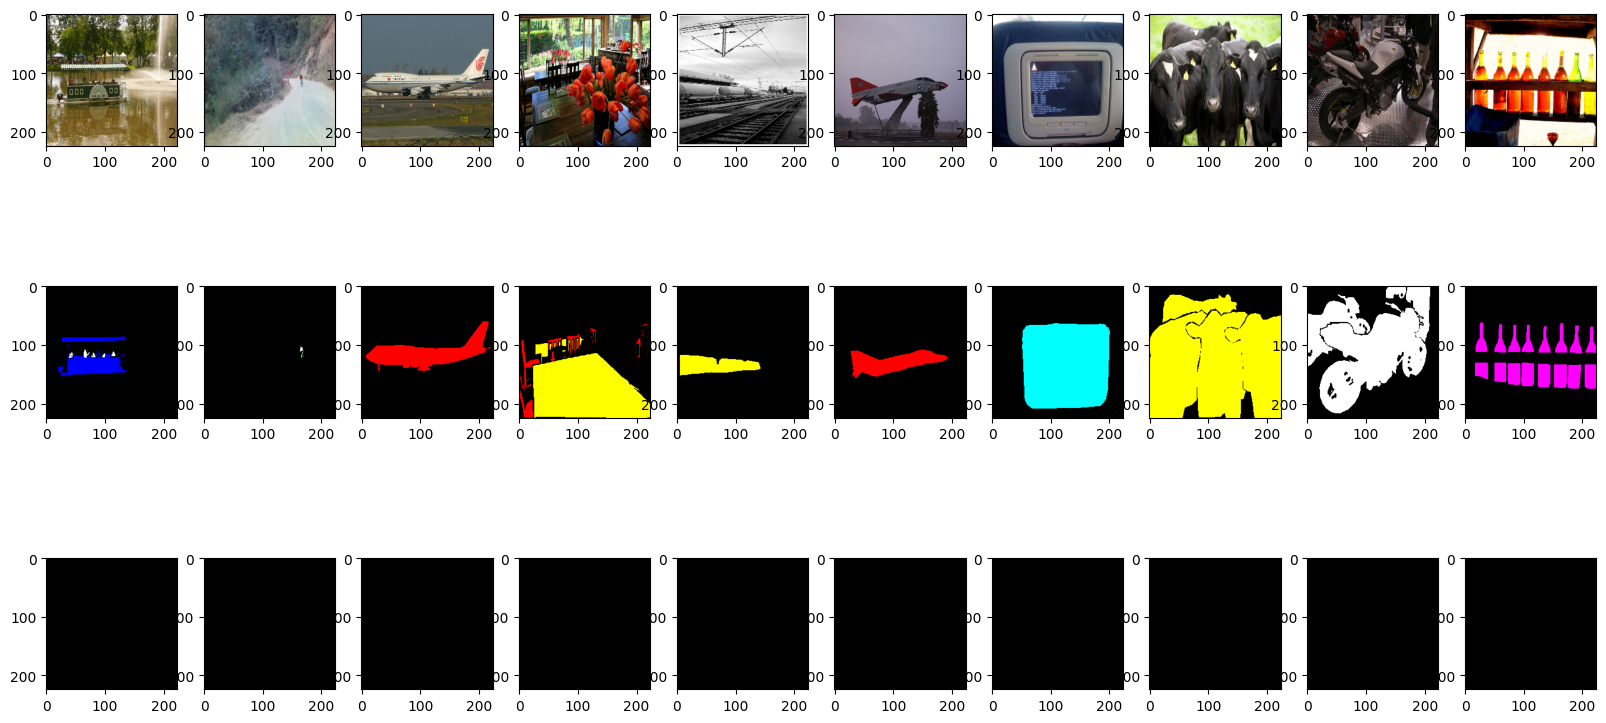

In [18]:
pred_show_image_grid(model_pth,model, device, test_transform, num_classes, num_imgs, assigned_ids = None)

indexs: [1231, 772, 48, 368, 1144, 1443, 700, 610, 511, 753]
y_shape =  torch.Size([1, 21, 224, 224])
tensor([[[[ 0.9997,  0.9997,  0.9997,  ...,  0.9997,  0.9997,  0.9997],
          [ 0.9997,  0.9997,  0.9997,  ...,  0.9997,  0.9997,  0.9997],
          [ 0.9997,  0.9997,  0.9997,  ...,  0.9997,  0.9997,  0.9997],
          ...,
          [ 0.9997,  0.9997,  0.9997,  ...,  0.9997,  0.9997,  0.9997],
          [ 0.9997,  0.9997,  0.9997,  ...,  0.9997,  0.9997,  0.9997],
          [ 0.9997,  0.9997,  0.9997,  ...,  0.9997,  0.9997,  0.9997]],

         [[-0.9997, -0.9997, -0.9997,  ..., -0.9997, -0.9997, -0.9997],
          [-0.9997, -0.9997, -0.9997,  ..., -0.9997, -0.9997, -0.9997],
          [-0.9997, -0.9997, -0.9997,  ..., -0.9997, -0.9997, -0.9997],
          ...,
          [-0.9997, -0.9997, -0.9997,  ..., -0.9997, -0.9997, -0.9997],
          [-0.9997, -0.9997, -0.9997,  ..., -0.9997, -0.9997, -0.9997],
          [-0.9997, -0.9997, -0.9997,  ..., -0.9997, -0.9997, -0.9997]],



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..64.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].
Clipping input data to the valid range for imshow with RGB data

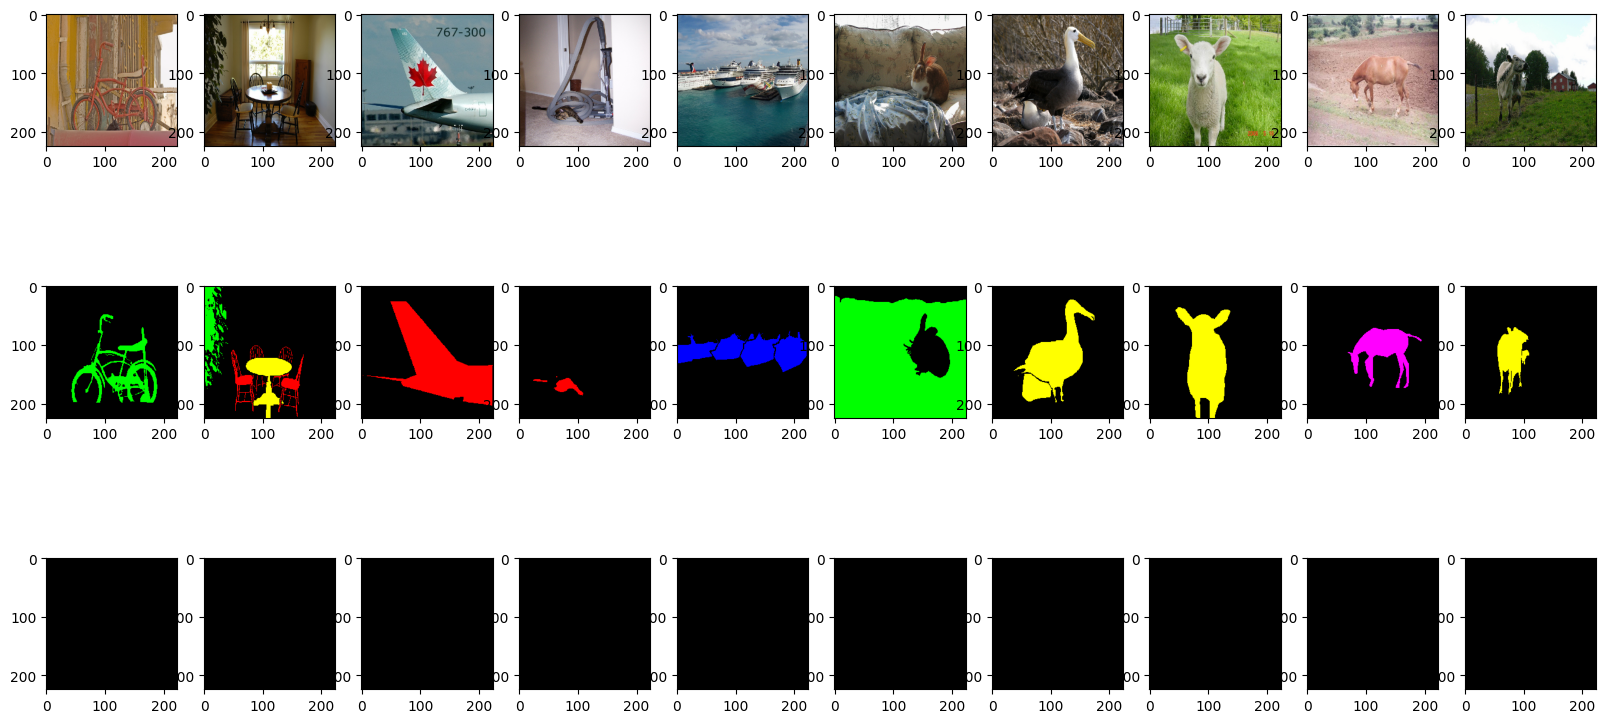

In [20]:
pred_show_image_grid(model_pth,model, device, test_transform, num_classes, num_imgs, assigned_ids = [1231, 772, 48, 368, 1144, 1443, 700, 610, 511, 753])

indexs: [58, 89, 25, 32, 4, 64, 88, 85, 28, 38]
y_shape =  torch.Size([1, 21, 224, 224])
tensor([[[[ 0.9997,  0.9997,  0.9997,  ...,  0.9997,  0.9997,  0.9997],
          [ 0.9997,  0.9997,  0.9997,  ...,  0.9997,  0.9997,  0.9997],
          [ 0.9997,  0.9997,  0.9997,  ...,  0.9997,  0.9997,  0.9997],
          ...,
          [ 0.9996,  0.9996,  0.9996,  ...,  0.9997,  0.9997,  0.9997],
          [ 0.9996,  0.9996,  0.9996,  ...,  0.9997,  0.9997,  0.9997],
          [ 0.9996,  0.9996,  0.9996,  ...,  0.9997,  0.9997,  0.9997]],

         [[-0.9997, -0.9997, -0.9997,  ..., -0.9997, -0.9997, -0.9997],
          [-0.9997, -0.9997, -0.9997,  ..., -0.9997, -0.9997, -0.9997],
          [-0.9997, -0.9997, -0.9997,  ..., -0.9997, -0.9997, -0.9997],
          ...,
          [-0.9996, -0.9996, -0.9996,  ..., -0.9997, -0.9997, -0.9997],
          [-0.9996, -0.9996, -0.9996,  ..., -0.9997, -0.9997, -0.9997],
          [-0.9996, -0.9996, -0.9996,  ..., -0.9997, -0.9997, -0.9997]],

         [[-0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB dat

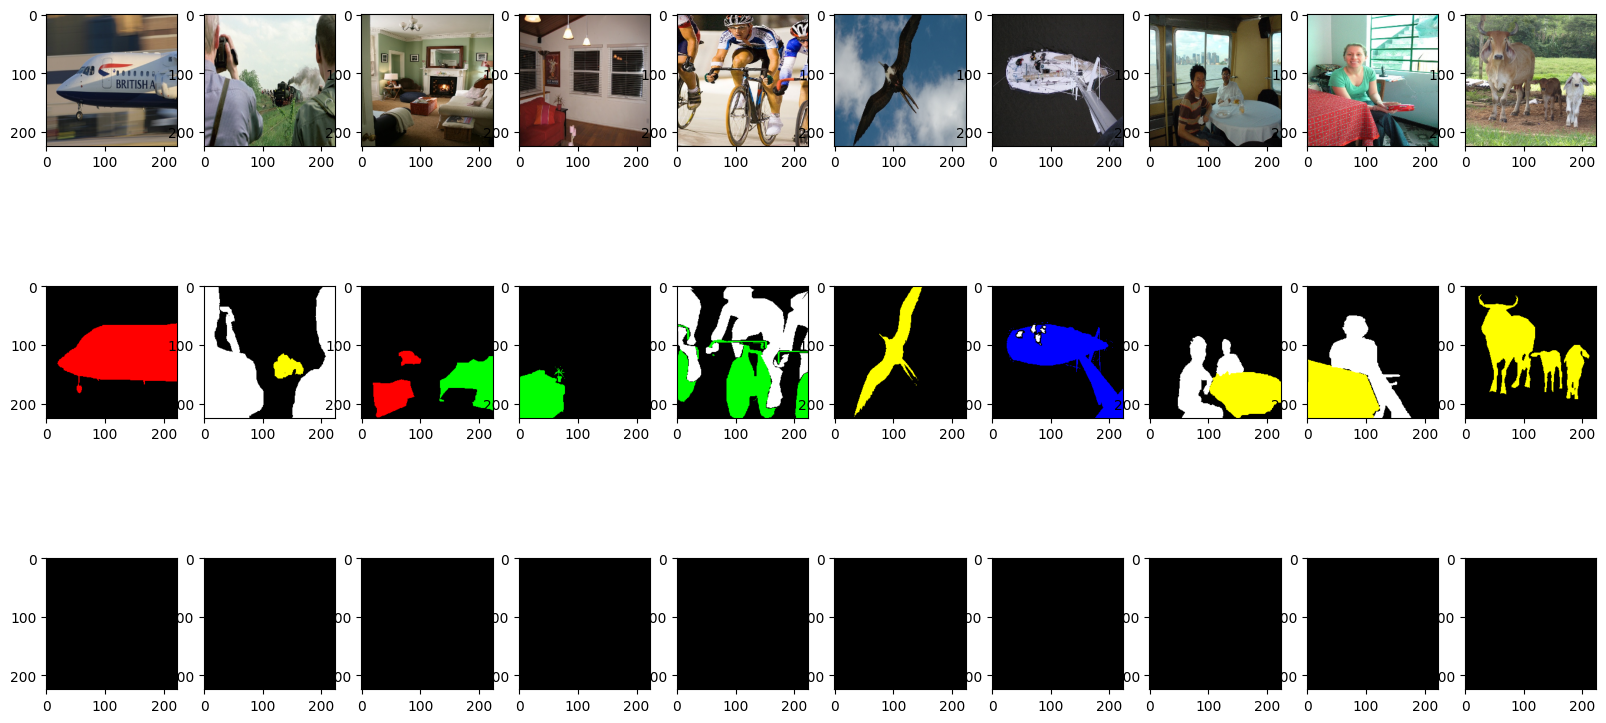

In [21]:
pred_show_image_grid(model_pth,model, device, test_transform, num_classes, num_imgs, assigned_ids = [58, 89, 25, 32, 4, 64, 88, 85, 28, 38])